<a href="https://colab.research.google.com/github/GeorgeOgeorge/hltv_datamining_analisys/blob/master/analise_explicita.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise explícita dos dados referentes ao dataset contendo a informação da performance dos jogadores de Counter Strike

A análise tem o intuito de responder quatro hipóteses formuladas pelos componentes da dupla

*   George Mendonça
*   Pedro Ricardo



Hipoteses:


1.   Quais as colunas mais significativas para ser um bom jogador?
2.   Quais os melhores times baseados nas colunas de teamWork?
3.   Bons jogadores individuais são bons jogadores em equipe?
4.   Quais os melhores times baseados nas estatísticas de rating individual? 


## Importando pacotes e abrindo o dataset

In [250]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from IPython.display import Image
from wordcloud import WordCloud, STOPWORDS
pd.options.display.float_format = '{:,.2f}'.format

In [251]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive


In [252]:
df = pd.read_csv("players_score.csv")
df

,nickname,name,nationality,team,total_kills,headshot_%,total_deaths,kills/deaths,damage/round,grenade_dmg/round,maps_played,rounds_played,kills/round,assists/round,deaths/round,saved_by_teammate/round,saved_teammates/round,rating
0,ZywOo,Mathieu Herbaut,France,Vitality,"2,083,500.00%","4,140.00%","1,508,600.00%",138.00%,"8,880.00%",360.00%,"93,400.00%","2,450,200.00%",85.00%,13.00%,62.00%,10.00%,12.00%,133.00%
1,s1mple,Aleksandr Kostyliev,Ukraine,Natus Vincere,"3,365,100.00%","4,140.00%","2,511,900.00%",134.00%,"8,650.00%",230.00%,"149,100.00%","3,933,500.00%",86.00%,10.00%,64.00%,8.00%,11.00%,125.00%
2,sh1ro,Dmitry Sokolov,Russia,Gambit,"1,644,600.00%","2,780.00%","1,142,800.00%",144.00%,"7,860.00%",390.00%,"80,500.00%","2,138,600.00%",77.00%,11.00%,53.00%,8.00%,11.00%,126.00%
3,Kaze,Andrew Khong,Malaysia,ViCi,"1,641,000.00%","3,030.00%","1,245,100.00%",132.00%,"8,050.00%",290.00%,"80,100.00%","2,091,100.00%",78.00%,11.00%,60.00%,8.00%,10.00%,119.00%
4,sterling,Euan Moore,New Zealand,LookingForOrg,"1,588,600.00%","3,150.00%","1,189,800.00%",134.00%,"7,910.00%",400.00%,"78,800.00%","2,020,300.00%",79.00%,10.00%,59.00%,8.00%,11.00%,122.00%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
780,B1ad3,Andrey Gorodenskiy,Ukraine,Natus Vincere,"1,347,200.00%","4,190.00%","1,688,000.00%",80.00%,"6,650.00%",260.00%,"89,900.00%","2,323,200.00%",58.00%,16.00%,73.00%,10.00%,7.00%,83.00%
781,netrick,Jonas Wenzelsen,Denmark,AGF,"674,000.00%","4,820.00%","847,200.00%",80.00%,"6,670.00%",660.00%,"45,400.00%","1,195,200.00%",56.00%,14.00%,71.00%,11.00%,9.00%,82.00%
782,HUNDEN,Nicolai Petersen,Denmark,No team,"2,247,000.00%","4,870.00%","2,870,800.00%",78.00%,"6,440.00%",450.00%,"157,800.00%","4,115,300.00%",55.00%,14.00%,70.00%,11.00%,9.00%,81.00%
783,RuFire,Aleksei Burakov,Russia,VP.Prodigy,"551,700.00%","4,800.00%","740,300.00%",75.00%,"6,660.00%",470.00%,"37,900.00%","1,005,300.00%",55.00%,14.00%,74.00%,9.00%,6.00%,84.00%



## Quais as colunas mais significativas para ser um bom jogador?

Conclusão:


*   **headshot_%** : Aponta a capacidade de precisão e reflexo de um jogador.
*   **kills/deaths**: Uma média que é calculada a partir do número de mortes e kills, percorrer de todo o historico do jogador, um K/D positivo indica que o jogador é alguém experiente.
*   **kills/round**: Um valor alto de K/R indica uma boa taxa de conversão por partida, no contexto dos jogos esse valor indica que para cada partida jogada, o jogador elimina certa quantidade de inimigos antes de ser eliminado, por conseqüência, ajudando seus companheiros de equipe.
*   **assists/round**: A taxa de assistência é algo secundário para um jogador, pois consideramos que o objetivo do jogador é pessoalmente eliminar os inimigos, porem não deixa de ser uma metrica importante nos jogos em equipe.
*   **deaths/round**: Valor que indica a quantidade de mortes do jogador por partida, quão menor for seu valor, melhor será o jogador pois indica que é capaz de sobreviver por mais tempo. Tem comportamento inversamente proporcional à taxa K/D


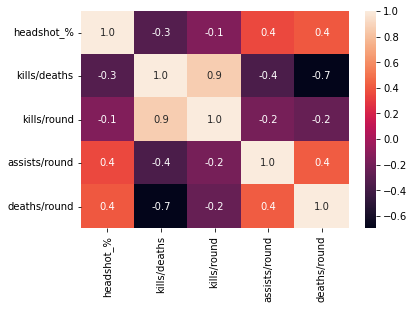

In [253]:
#Fazendo mapa de calor de correlação da metricas selecionadas 
metricas_jogadores = df[['headshot_%', 'kills/deaths', 'kills/round', 'assists/round', 'deaths/round']]
corr = metricas_jogadores.select_dtypes(exclude='object').corr()
sb.heatmap(corr, annot=True, fmt=".1f")

### Exemplo correlação positiva

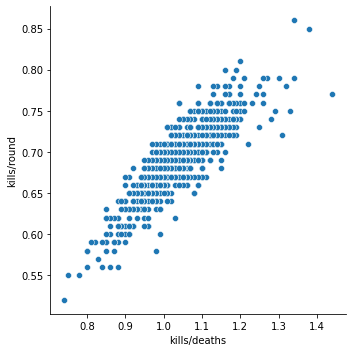

In [254]:
sb.relplot(data=metricas_jogadores, x='kills/deaths', y='kills/round')

### Exemplo correlação negativa

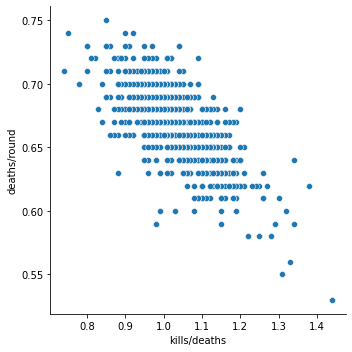

In [255]:
sb.relplot(data=metricas_jogadores, x='kills/deaths', y='deaths/round')

### Exemplo sem correlação

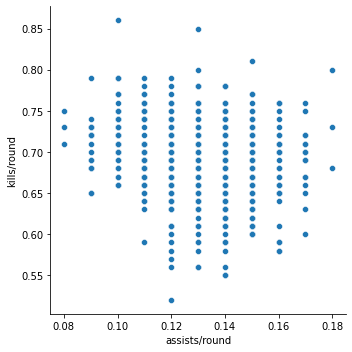

In [256]:
sb.relplot(data=metricas_jogadores, x='assists/round', y='kills/round')

## Quais os melhores times baseados nas colunas de teamWork?

Os times com melhor performance na categoria de trabalho em equipe são:


1. Liquid
2. Extra Salt
3. Heroic
4. G2
5. MIBR


obs: As métricas utilizadas foram
* assistencias/round
* salvo por parceiro de time/round
* salvou parceiro de time/round

obs 2: 307 jogadores não possuíam time

In [257]:
# selecionando apenas jogadores com time
jogadores_com_time = df[df.team != "No team"]
# dropando colunas desnecessarias
jogadores_com_time = jogadores_com_time.drop(columns=['nickname', 'name', 'nationality'])
# crinado lista de jogadores para filtragem futura
lista_times = []
# buscando jogador por jogador e somando seus dados para uma linha contendo a soma de todos os dados do time
for team in jogadores_com_time['team']:
  lista_times.append(jogadores_com_time.loc[(jogadores_com_time['team'] == team)].sum())
df_times = pd.DataFrame(lista_times, columns= ['team', 'total_kills', 'headshot_%', 'total_deaths', 'kills/deaths', 'damage/round', 'grenade_dmg/round',
                                               'maps_played', 'rounds_played', 'kills/round', 'assists/round', 'deaths/round', 'saved_by_teammate/round',
                                               'saved_teammates/round', 'rating'])
# dropando linhas duplicadas
df_times = df_times.drop_duplicates(subset=['team'])

In [258]:
# selecionando apenas as colunas importantes para a análise
df_times = df_times[['team', 'assists/round', 'saved_by_teammate/round', 'saved_teammates/round']]
df_times.describe()

,assists/round,saved_by_teammate/round,saved_teammates/round
count,"17,300.00%","17,300.00%","17,300.00%"
mean,35.91%,26.35%,26.65%
std,22.29%,16.07%,16.67%
min,9.00%,7.00%,6.00%
25%,14.00%,10.00%,10.00%
50%,28.00%,22.00%,21.00%
75%,53.00%,39.00%,39.00%
max,97.00%,70.00%,74.00%


In [259]:
# calculando a média final de cada time 
direita = df_times[['assists/round', 'saved_by_teammate/round', 'saved_teammates/round']].mean(axis=1)
direita = direita.to_frame()
direita = direita.rename(columns={0: "rating"}, inplace = False)
times_rank = df_times[['team']].join(direita)
times_rank.sort_values(by=['rating'], ascending=False)

,team,rating
39,LiquidLiquidLiquidLiquidLiquidLiquidLiquid,80.33%
58,Extra SaltExtra SaltExtra SaltExtra SaltExtra ...,70.67%
144,HeroicHeroicHeroicHeroicHeroicHeroic,66.67%
13,G2G2G2G2G2G2,65.00%
76,MIBRMIBRMIBRMIBRMIBRMIBR,65.00%
...,...,...
86,GamerS1337,9.67%
111,Let's Quit,9.00%
31,HellRaisers,8.67%
227,ex-Maknitude,8.67%


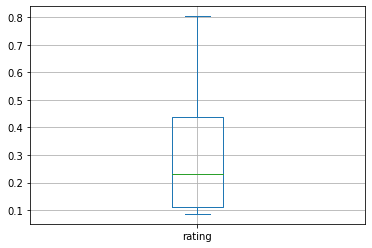

In [260]:
times_rank['rating'].plot.box(grid = True)

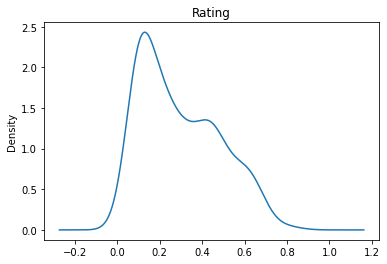

In [261]:
times_rank['rating'].plot.kde(title='Rating')

## Bons jogadores individuais são bons jogadores em equipe?

Concluímos que a maioria dos jogadores com maior ranking (foram selecionados os 100 melhores), possuem uma performance satisfatória se compararmos suas capacidades solo ou em equipe. Vemos que esses valores são diretamente proporcionais, algo que vem como conseqüência da cena profissional de um esporte eletrônico.

Colunas utilizadas para determinar a performance solo:
* headshot % 
* kills/deaths 
* damage/round 
* grenade_dmg/round
* kills/round

Colunas utilizadas para determinar a performance em equipe:

* assists/round
* deaths/round 
* saved_by_teammate/round
* saved_teammates/round

In [314]:
df_jogadores = df.sort_values(by=['rating'], ascending=False).head(100)[['nickname']]
df_individuais = df.sort_values(by=['rating'], ascending=False).head(100)[['headshot_%', 'kills/deaths', 'damage/round', 'grenade_dmg/round', 'kills/round']]
df_equipe = df.sort_values(by=['rating'], ascending=False).head(100)[['assists/round', 'deaths/round', 'saved_by_teammate/round', 'saved_teammates/round']]

In [315]:
# fazendo a média dos valores que representam a performance individual do jogador
df_individuais = df_individuais[['headshot_%', 'kills/deaths', 'damage/round', 'grenade_dmg/round', 'kills/round']].mean(axis=1)
df_individuais = df_individuais.to_frame()
df_individuais = df_individuais.rename(columns={0: "solo"}, inplace = False)

# fazendo a média dos valores que representam a performance em time do jogador
df_equipe = df_equipe[['assists/round', 'deaths/round', 'saved_by_teammate/round', 'saved_teammates/round']].mean(axis=1)
df_equipe = df_equipe.to_frame()
df_equipe = df_equipe.rename(columns={0: "team_work"}, inplace = False)

# convertendo os valores da performance do jogador para %
df_equipe = pd.Series(["{0:.2f}".format(val * 100) for val in df_equipe['team_work']], index = df_equipe.index)
df_equipe = df_equipe.to_frame()
df_equipe = df_equipe.rename(columns={0: 'team_work'}, inplace = False)
df_equipe = df_equipe['team_work'].astype(float)

In [316]:
# unindo colunas caluladas para cada jogador em um unico dataframe 
df_jogadores = df_jogadores.join(df_individuais)
df_jogadores = df_jogadores.join(df_equipe)
df_jogadores.sort_values(by=['team_work'], ascending=False).head(100)

,nickname,solo,team_work
21,Texta,26.59,27.25
42,wrath,27.88,27.00
114,Xeppaa,27.75,26.75
131,trk,27.01,26.50
185,roeJ,28.98,26.50
...,...,...,...
65,hades,21.78,21.75
2,sh1ro,22.50,20.75
34,xsepower,20.40,20.25
20,Jame,20.95,20.00


In [317]:
# quanto mais proximo de 0 mais equilibrado é o jogador
jogadores_diferenca = df_jogadores['solo'] - df_jogadores['team_work']
jogadores_diferenca = jogadores_diferenca.to_frame()
jogadores_diferenca = jogadores_diferenca.rename(columns={0: 'diferenca'}, inplace = False)
df_jogadores = df_jogadores.join(jogadores_diferenca).sort_values(by=['diferenca'], ascending=False).head(100)

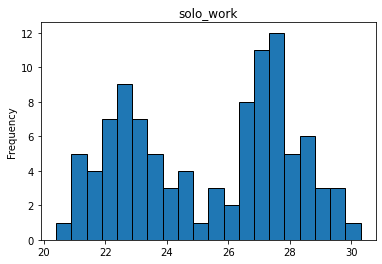

In [322]:
df_jogadores['solo'].plot.hist(title='solo_work', edgecolor='black', bins = 20) 

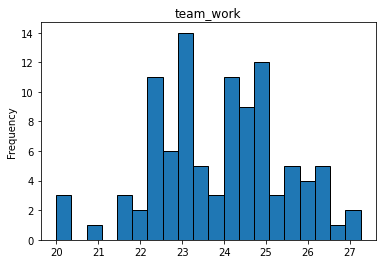

In [323]:
# valores são inversamente proporcionais
df_jogadores['team_work'].plot.hist(title='team_work', edgecolor='black', bins = 20) 

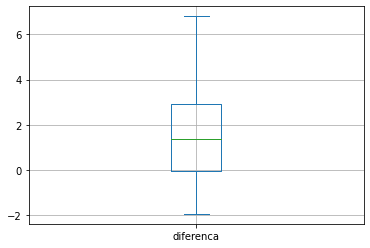

In [319]:
df_jogadores['diferenca'].plot.box(grid = True)

## Quais são os melhores times baseados nas estatísticas de rating individual?

Conclusões:

* Times com mais de 5 componentes são estão com um excedente de jogadores reserva ou jogadores que passaram pelo time recentemente e ainda possuem registro

* Times com menos de 4 componentes são aqueles aonde jogadores não estão na lista ou que perderam seus jogadores recentemente

Melhores times:

1. Liquid
2. Extra Salt
3. Heroic
4. G2
5. MIBR

In [332]:
df_times = pd.DataFrame(lista_times, columns= ['team', 'total_kills', 'headshot_%', 'total_deaths', 'kills/deaths', 'damage/round', 'grenade_dmg/round',
                                               'maps_played', 'rounds_played', 'kills/round', 'assists/round', 'deaths/round', 'saved_by_teammate/round',
                                               'saved_teammates/round', 'rating'])
df_times = df_times[['team','rating']]
df_times = df_times.drop_duplicates(subset=['team'])
df_times.sort_values(by=['rating'], ascending=False)

,team,rating
39,LiquidLiquidLiquidLiquidLiquidLiquidLiquid,7.43
19,Virtus.proVirtus.proVirtus.proVirtus.proVirtus...,6.62
58,Extra SaltExtra SaltExtra SaltExtra SaltExtra ...,6.60
13,G2G2G2G2G2G2,6.48
76,MIBRMIBRMIBRMIBRMIBRMIBR,6.45
17,AstralisAstralisAstralisAstralisAstralisAstralis,6.45
144,HeroicHeroicHeroicHeroicHeroicHeroic,6.43
7,MOUZMOUZMOUZMOUZMOUZMOUZ,6.40
1,Natus VincereNatus VincereNatus VincereNatus V...,6.39
33,SKADESKADESKADESKADESKADESKADE,6.37


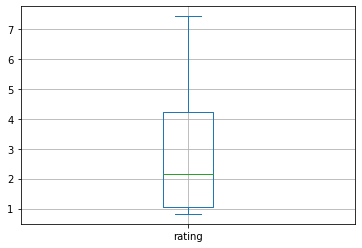

In [334]:
df_times['rating'].plot.box(grid = True)